Load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

path = r"C:\Users\Surface\Masterarbeit\data\Baseline.xlsx"

df = pd.read_excel(path)


Transformation Pipeline

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# get the numerical features
data_num = df.drop('x_Einzug [mm]', axis = 1)
# get the target values
data_labels = df['x_Einzug [mm]'].to_numpy()

# pipeline for preprocessing the data

# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

data_prep = data_pipeline.fit_transform(data_num)

X_train, X_test, y_train, y_test = train_test_split(data_prep, data_labels, test_size= 0.2, random_state=42)


Model Testing Random Forest

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

#define model, 50 different trees
rnd_reg = RandomForestRegressor(n_estimators=50, n_jobs=-1)

#train model
rnd_reg.fit(X_train, y_train)

#prepare a data frame for the important features
importances = rnd_reg.feature_importances_
features = ['Matrizenradius [mm ]', 'Stempelkantenradius [mm]', 'Blechdicke [mm]',
            'Platinenabmessung [mm]', '1/4 Niederhalterkraft [N]', 'Ziehtiefe [mm]']

# Create a DataFrame to display feature importance, sorted descending
feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#show important features
display(feat_df)

#make some predicitons on train and test dataset
y_train_pred = rnd_reg.predict(X_train)
y_test_pred = rnd_reg.predict(X_test)

#calculate R2 Score for train and test data
r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

#Compare R2 Score for the first 10 instances
vergleich_df = pd.DataFrame({
    'True value' : y_test[:10],
    'Prediction' : y_test_pred[:10].flatten(),
    'Difference' : y_test[:10] - y_test_pred[:10].flatten()
 })
#print the result
print(f'\nR² Train: {r2_train:.4f} | R² Test: {r2_test:.4f}')
display(vergleich_df.style.background_gradient(cmap='RdYlGn_r'))

## Uncertainty for RF --> commin soon



,Feature,Importance
5,Ziehtiefe [mm],0.665160
1,Stempelkantenradius [mm],0.167637
3,Platinenabmessung [mm],0.159158
4,1/4 Niederhalterkraft [N],0.005136
0,Matrizenradius [mm ],0.001989
2,Blechdicke [mm],0.000920



R² Train: 0.9998 | R² Test: 0.9990


,True value,Prediction,Difference
0,6.590000,6.547920,0.042080
1,8.100000,8.085030,0.014970
2,9.231000,9.191330,0.039670
3,7.623000,7.586890,0.036110
4,9.253500,9.263670,-0.010170
5,10.484500,10.477410,0.007090
6,8.219000,8.178080,0.040920
7,6.679500,6.673050,0.006450
8,8.614500,8.574070,0.040430
9,7.534500,7.577280,-0.042780


Quantil Regression Forest, build on original forest, approximation because only the mean of each choosen leaf is used, not the real distribution in leaf node --> skgarden funktioniert aber nicht

,Feature,Importance
5,Ziehtiefe [mm],0.660863
3,Platinenabmessung [mm],0.166208
1,Stempelkantenradius [mm],0.165120
4,1/4 Niederhalterkraft [N],0.004883
0,Matrizenradius [mm ],0.001931
2,Blechdicke [mm],0.000994


Quantil 2.5 (Median) der Vorhersagen:
 [ 6.5198     8.0121875  9.1975     7.5895     9.0610875 10.317
  8.1516     6.5948     8.5455     7.389275   9.8395     6.9825
  7.9705     7.122525   6.3213875  8.5885     8.1064625  6.9012625
  9.714      8.0440375  7.5891125  7.8860125  9.8675     6.8179
  7.5887625  7.0576     9.2865     7.4035375  6.3613375  6.8809
  8.661      8.3547     7.1573375  9.8675     6.3213875  6.110875
  7.3715     9.8476     8.6645     9.125      8.5885     7.3804
  6.3337875  6.1565     6.9645     9.176675  10.299      7.0495
  8.056625   7.443      8.1649375  7.678      6.043      6.3285
  9.1935     9.6895     6.7218     7.8860125  9.12       8.0384625
  8.3685     6.7218     9.9745     8.714075   6.2055     9.7625
  7.5483375  7.6515    10.597075   9.2395     9.3110875  6.715275
  6.5948     7.917      7.6515     6.9852375 10.317      7.0445
  6.6395375  7.383      9.0225     6.2055     9.018125   8.183
  9.0557875  7.0405     6.8665     6.94       7.056      

,True value,Prediction,Difference
0,6.590000,6.557000,0.033000
1,8.100000,8.085500,0.014500
2,9.231000,9.197500,0.033500
3,7.623000,7.589500,0.033500
4,9.253500,9.293000,-0.039500
5,10.484500,10.354500,0.130000
6,8.219000,8.179500,0.039500
7,6.679500,6.696500,-0.017000
8,8.614500,8.582000,0.032500
9,7.534500,7.590500,-0.056000


Coverage: 69.18%


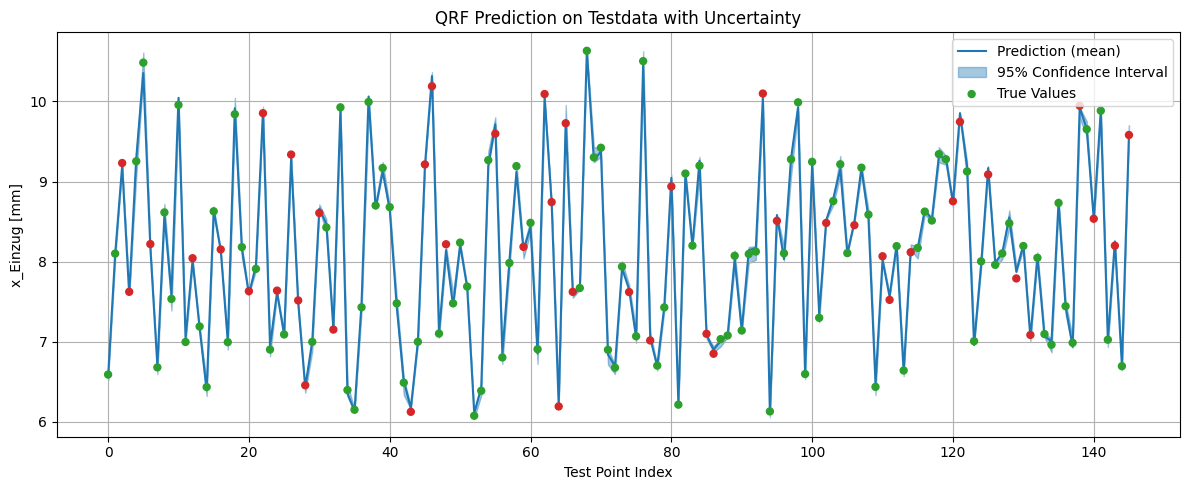

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np

#define model, 50 different trees
rnd_reg = RandomForestRegressor(n_estimators=10, n_jobs=-1)

#train model
rnd_reg.fit(X_train, y_train)

#prepare a data frame for the important features
importances = rnd_reg.feature_importances_
features = ['Matrizenradius [mm ]', 'Stempelkantenradius [mm]', 'Blechdicke [mm]',
            'Platinenabmessung [mm]', '1/4 Niederhalterkraft [N]', 'Ziehtiefe [mm]']

# Create a DataFrame to display feature importance, sorted descending
feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#show important features
display(feat_df)

#calculate the predictions for each tree on the training data for R² Score
predictions_train = np.array([tree.predict(X_train) for tree in rnd_reg.estimators_])
quantil_50_train = np.percentile(predictions_train, 50, axis = 0)

#calculate the predictions for each tree
predictions = np.array([tree.predict(X_test) for tree in rnd_reg.estimators_])

#get the quantils
quantil_2_5 = np.percentile(predictions, 2.5, axis = 0)
quantil_50 = np.percentile(predictions, 50, axis = 0)
quantil_97_5 = np.percentile(predictions, 97.5, axis = 0)

# Zeige das Ergebnis für das 50. Quantil (Median) an
print("Quantil 2.5 (Median) der Vorhersagen:\n", quantil_2_5)
print("Quantil 50 (Median) der Vorhersagen:\n", quantil_50)
print("Quantil 97.5 (Median) der Vorhersagen:\n", quantil_97_5)

r2_train = r2_score(y_train, quantil_50_train)
r2_test = r2_score(y_test,quantil_50)

#Compare R2 Score for the first 10 instances
vergleich_df = pd.DataFrame({
    'True value' : y_test[:10],
    'Prediction' : quantil_50[:10].flatten(),
    'Difference' : y_test[:10] - quantil_50[:10].flatten()
 })
#print the result
print(f'\nR² Train: {r2_train:.4f} | R² Test: {r2_test:.4f}')
display(vergleich_df.style.background_gradient(cmap='RdYlGn_r'))

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test >= quantil_2_5) & (y_test <= quantil_97_5)
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(len(X_test))

# Plot predicted mean
plt.plot(x_axis, quantil_50, label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, quantil_2_5, quantil_97_5,
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test, label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("QRF Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()